# Application: Blackbody Radiation

The spectrum of a star is well approximated as a [blackbody](https://en.wikipedia.org/wiki/Black-body_radiation). The Planck function describes the intensity of a blackbody:
    
$$B_\lambda = \frac{2 h c^2}{\lambda^5} \frac{1}{\exp\left (\frac{hc}{\lambda k_B T}\right) - 1}$$

This has units of energy / area / wavelength / steradian.  

## Integrating over wavelength
Let's integrate out wavelength:

$$B = \int_0^\infty B_\lambda d\lambda$$

our integral is then:

$$B = 2 h c^2 \int_0^\infty \frac{1}{\lambda^5} \frac{1}{\exp\left (\frac{hc}{\lambda k_B T}\right) - 1} d\lambda$$

defining a dimensional quantity, $x$:

$$x = \frac{hc}{\lambda k_B T}$$

we have

$$dx = - \frac{hc}{\lambda^2 k_B T} d\lambda = - \frac{x^2k_BT}{hc} d\lambda$$

finally, we have:

$$B = \frac{2(k_B T)^4}{h^3 c^2} \int_0^\infty \frac{x^3}{e^x - 1} dx$$

## Integrating to infinity

Now the challenge becomes &mdash; how do we do this integral, when the integration limits extend to infinity!

Note: it turns out that this integral has an analytic solution:

$$\int_0^\infty \frac{x^3}{e^x - 1} dx = \frac{\pi^4}{15}$$

and the original integral is

$$B = \frac{\sigma T^4}{\pi}$$

with the [Stephan-Boltzmann constant](https://en.wikipedia.org/wiki/Stefan%E2%80%93Boltzmann_constant) defined as:

$$\sigma \equiv \frac{2 k_B^4 \pi^5}{15 h^3 c^2}$$

so we can check our answer.

```{tip}
It's always a good idea to start by plotting the integrand.
```

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def B(x):
    """the Planck function kernel, in terms of x = h c / lambda k T"""
    # we need to take the limit x -> 0 if the input x is 0
    return np.where(x == 0, 0, x**3 / (np.expm1(x)))

/tmp/ipykernel_369190/3072722118.py:4: RuntimeWarning: invalid value encountered in divide
  return np.where(x == 0, 0, x**3 / (np.expm1(x)))


Text(0, 0.5, '$x^3 / (e^x - 1)$')

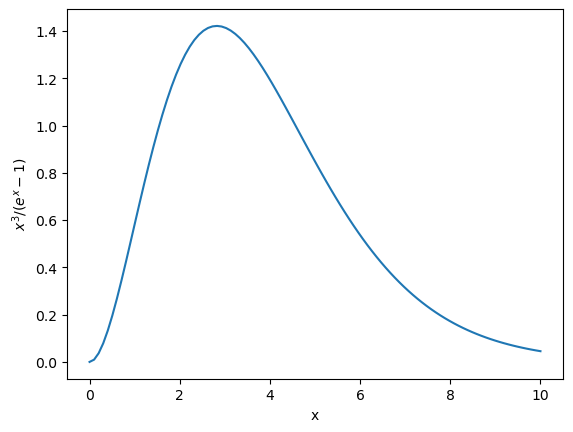

In [5]:
fig = plt.figure()
ax = fig.add_subplot()

x = np.linspace(0, 10, 100)
ax.plot(x, B(x))
ax.set_xlabel("x")
ax.set_ylabel(r"$x^3 / (e^x - 1)$")

From the plot, we see that it peaks near x = 3 and then drops off, but it will only asymptotically approach `0`, so we need to still be careful about the integration limits.

Let's consider the transform:

$$z = \frac{x}{\alpha + x}$$

where $\alpha$ is chosen to be close to the maximum of the integrand.  This transformation maps the interval $x \in [0, \infty)$ into $z \in [0, 1)$ &mdash; that makes the integral finite, and we can use our methods (like trapezoid) to do it.

The inverse transform is:

$$x = \alpha \frac{z}{1 - z}$$

In [6]:
SMALL = 1.e-30

def zv(x, alpha=1):
    """ transform the variable x -> z """
    return x/(alpha + x) 

def xv(z, alpha=1):
    """ transform back from z -> x """
    return alpha*z/(1.0 - z + SMALL)

Let's plot it again, but in terms of $z$

/tmp/ipykernel_369190/3072722118.py:4: RuntimeWarning: overflow encountered in expm1
  return np.where(x == 0, 0, x**3 / (np.expm1(x)))
/tmp/ipykernel_369190/3072722118.py:4: RuntimeWarning: invalid value encountered in divide
  return np.where(x == 0, 0, x**3 / (np.expm1(x)))


Text(0, 0.5, '$x(z)^3 / (e^(x(z)) - 1)$')

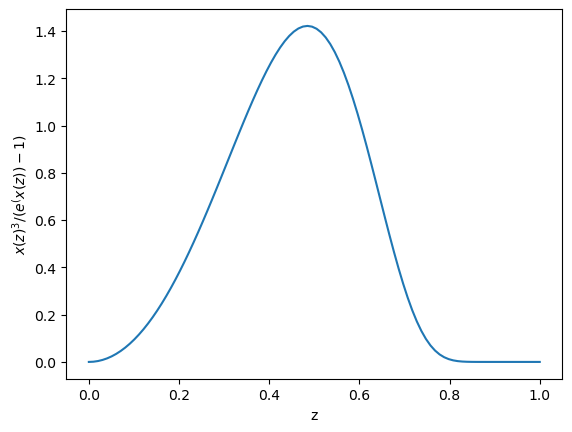

In [7]:
z = np.linspace(0, 1, 100)
alpha = 3

fig, ax = plt.subplots()
ax.plot(z, B(xv(z, alpha)))
ax.set_xlabel("z")
ax.set_ylabel(r"$x(z)^3 / (e^(x(z)) - 1)$")

Notice that the transform puts the peak near the center of the interval, and the function nicely goes to zero as $z\rightarrow 1$.  This is much better behaved to integrate.

Consider a general integral:

$$I = \int_0^\infty f(x) dx$$

Let's rewrite this in terms of $z$. Since

$$x = \alpha \frac{z}{1 - z}$$

we have

$$dx = \frac{\alpha dz}{(1 - z)^2}$$

so

$$I = \alpha \int_0^1 f\left(\alpha \frac{z}{1 - z} \right ) (1 -z)^{-2} dz$$

We need to include these extra factors in our quadrature for computing the integral.

```{note}
For integrals over $[-\infty, \infty]$ a different change of variables would be needed.  See, e.g.,
[Wikipedia article on numerical integration](https://en.wikipedia.org/wiki/Numerical_integration#Integrals_over_infinite_intervals)
```


In [9]:
def I_t(func, N=10, alpha=5):
    """composite trapezoid rule for integrating from [0, oo].
    Here N is the number of intervals"""
    
    # there are N+1 points corresponding to N intervals
    z = np.linspace(0.0, 1.0, N+1, endpoint=True)
    
    I = 0.0
    for n in range(N):
        I += 0.5 * (z[n+1] - z[n]) * (func(xv(z[n], alpha)) / (1.0 - z[n] + SMALL)**2 +
                                      func(xv(z[n+1], alpha)) / (1.0 - z[n+1] + SMALL)**2)
    I *= alpha
    return I

Now we can check our result.  First, let's compute the analytic solution:

In [10]:
I_analytic = np.pi**4/15

In [11]:
for nint in [2, 4, 8, 16, 32, 64]:
    I_trap = I_t(B, N=nint, alpha=3)
    print(f"{nint:5} {I_trap:10.5f} {np.abs(I_trap - I_analytic):20.10g}")

    2    8.48810          1.994163429
    4    6.09974         0.3941968295
    8    6.49205       0.001888841238
   16    6.49392      1.669019097e-05
   32    6.49394      5.396286928e-07
   64    6.49394      3.352448719e-08


/tmp/ipykernel_369190/3072722118.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return np.where(x == 0, 0, x**3 / (np.expm1(x)))
/tmp/ipykernel_369190/3072722118.py:4: RuntimeWarning: overflow encountered in expm1
  return np.where(x == 0, 0, x**3 / (np.expm1(x)))


We see that our answer matches the analytic solution very well.

## C++ implementation

A C++ implementation is available as: [blackbody.cpp](https://github.com/zingale/computational_astrophysics/blob/main/examples/integration/blackbody.cpp)

```{literalinclude} ../../../examples/integration/blackbody.cpp
:language: c++
```

## Did we need to scale?

We did our integral in terms of $x$ --- what would have happened if we did it in terms of $\lambda$?

In [12]:
def B_planck(lam, T=1.e4):
    """the full Planck function"""

    # CGS constants
    c = 2.99792e10  # cm/s
    k = 1.380649e-16  # erg/K
    h = 6.626070e-27  # erg s

    B = 2*h*c**2 / lam**5 / np.expm1(h*c/(lam*k*T))
    return np.where(lam == 0, 0, B)

Let's plot it with an evenly spaced $z$

In [13]:
T = 1.e4

In [14]:
z = np.linspace(0, 1, 50, endpoint=True)

/tmp/ipykernel_369190/3009151832.py:9: RuntimeWarning: divide by zero encountered in divide
  B = 2*h*c**2 / lam**5 / np.expm1(h*c/(lam*k*T))
/tmp/ipykernel_369190/3009151832.py:9: RuntimeWarning: invalid value encountered in divide
  B = 2*h*c**2 / lam**5 / np.expm1(h*c/(lam*k*T))


Text(0, 0.5, '$B_\\lambda$')

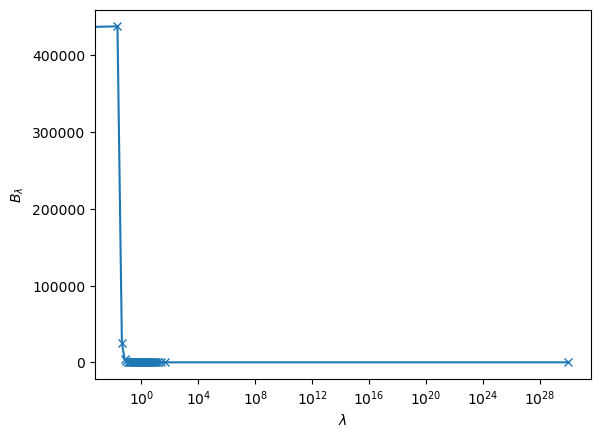

In [15]:
fig, ax = plt.subplots()
ax.plot(xv(z), B_planck(xv(z), T=T), marker="x")
ax.set_xscale("log")
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel(r"$B_\lambda$")

This does not look good.  All of the data points (the "x") are at wavelenghts much larger
than where we expect the peak to lie.

The issue is that we need to have our mapping know where the most interesting features are --- that's what 
the $\alpha$ parameter does.  Let's use [Wien's law](https://en.wikipedia.org/wiki/Wien%27s_displacement_law) to set $\alpha$

In [16]:
alpha = 0.29 / T   # 0.29 is in units nm K

/tmp/ipykernel_369190/3009151832.py:9: RuntimeWarning: divide by zero encountered in divide
  B = 2*h*c**2 / lam**5 / np.expm1(h*c/(lam*k*T))
/tmp/ipykernel_369190/3009151832.py:9: RuntimeWarning: invalid value encountered in divide
  B = 2*h*c**2 / lam**5 / np.expm1(h*c/(lam*k*T))


Text(0, 0.5, '$B_\\lambda$')

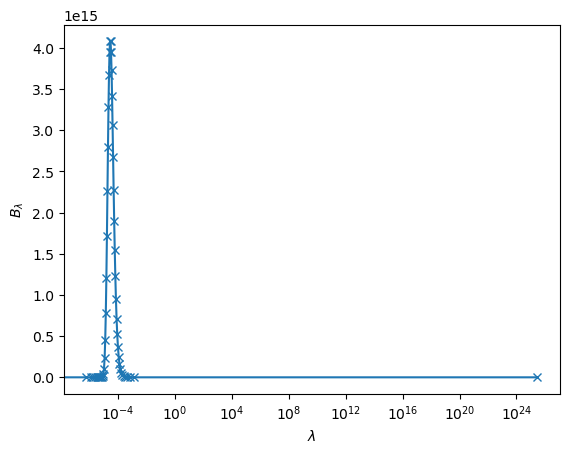

In [17]:
fig, ax = plt.subplots()
ax.plot(xv(z, alpha=alpha), B_planck(xv(z, alpha=alpha), T=T), marker="x")
ax.set_xscale("log")
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel(r"$B_\lambda$")

That looks a lot better --- now the points are concentrated in the peak.

Now let's see if we still get the right answer!

```{note}
Previously we were just integrating the dimensionless part of the Planck function, and we expected
to get $\pi^4/15$.

Now, we have all of the dimensional terms in our integrand, and we expect to get $\sigma T^4 / \pi$.
```

In [19]:
sigma = 5.670374e-5  # erg / cm^3 / K^4 / s

In [20]:
I = I_t(B_planck, N=50, alpha=alpha)
analytic = sigma * T**4 / np.pi
print(f"numerical = {I}; analytic = {analytic}")

numerical = 180494194227.23563; analytic = 180493610255.9526


/tmp/ipykernel_369190/3009151832.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  B = 2*h*c**2 / lam**5 / np.expm1(h*c/(lam*k*T))
/tmp/ipykernel_369190/3009151832.py:9: RuntimeWarning: invalid value encountered in scalar divide
  B = 2*h*c**2 / lam**5 / np.expm1(h*c/(lam*k*T))


The differences here are largely now due to the precision with which I entered the physical constants.